In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8,8))

import random
import os.path

import pycamhd.lazycache as lazycache     ## For accessing data through a Lazycache instance
import pycamhd.lazyqt as lazyqt           ## For accessing data on disk or through HTTP


import pycamhd_accessor as accessor

import json

## Local imports
from timer import Timer



from dask import compute,delayed,threaded,multiprocessing

In [2]:
video_lengths = dict()

In [3]:
## Default values

## These paths must exist in all locations ... the code doesn't check...
ci_url_root = "https://rawdata.oceanobservatories.org/files/"

paths = ['/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T000000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T030000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T060000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T090000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T120000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T150000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T180000Z.mov',
         '/RS03ASHS/PN03B/06-CAMHDA301/2016/01/01/CAMHDA301-20160101T210000Z.mov'
        ]
local_path = "/data"

local_cached_url   = 'http://localhost:8080/'
local_uncached_url = 'http://localhost:9080/'

local_nginx_url    = 'http://localhost:9081/'

gae_uncached_url   = 'https://camhd-app-dev-nocache.appspot.com/'
gae_cached_url   = 'https://camhd-app-dev.appspot.com/'

reps = 100

nthreads = [1,2,4,8]

import platform
hostname = platform.node()
config_file = "%s_config.json" % hostname

results_file = "%s_results.json" % hostname


In [4]:
## import local configuration
if os.path.isfile(config_file):
    print("Loading config file %s" % config_file)
    
    with open( config_file, 'r' ) as f:
        conf = json.load( f )

        
    if 'local_path' in conf.keys(): local_path = conf['local_path']
    if 'reps' in conf.keys():       reps = conf['reps']

Loading config file berna_config.json


In [5]:
print("Configuration")
print("Local_path: %s" % local_path )
print("Reps: %d" % reps )

Configuration
Local_path: /home/amarburg/rawdata.oceanobservatories.org/files
Reps: 100


In [6]:

def movie_length( movie ):
    if movie in video_lengths.keys():
        vid_length = video_lengths[ movie ]
    else:
        ## Retrieve (and cache) total number of frames in movie
        metadata = lazyqt.get_metadata( ci_url_root + movie )
        vid_length = metadata['num_frames']
        video_lengths[movie] = vid_length
    
    return vid_length

def random_frames( count, seed = -1 ):
    if seed >= 0: 
        print("Setting random seed to %d" % seed)
        rng = random.Random(seed)
    else:
        rng = random.Random()
        
    movies = rng.choices( paths, k=count )
    return [[m, rng.randrange( 1, movie_length(m) )] for m in movies]

def test_kernel( repo, frame ):
    with Timer() as t:
        ## Todo.   Check quality of outcome
        img = repo.get_frame( frame[0], frame[1] )
        if img is None:
            valid = False
        else:       
            sz = img.shape
            if (sz[0] == 1080) and (sz[1] == 1920):
                valid = True
            else:
                valid = False
            
    out =  {'valid': valid, 'path': frame[0], 'frame': frame[1]}
    if valid:
        out['msecs'] = t.msecs
        
    return out
                
def do_test_repo( repo, count, seed = -1, nthreads = 1 ):
    if nthreads == 1:
        results = [test_kernel( repo, frame ) for frame in random_frames( count, seed=seed )]  
    else:
        values = [delayed(test_kernel)( repo, frame ) for frame in random_frames( count, seed=seed )]  
        results = compute(*values, get=threaded.get, num_workers=nthreads)
    
    return results
    

def plot_times( results, desc ):
    msec = [t['msecs'] for t in results if t['valid']]
    if len(msec) < 1: return
    
    print("%s: %f ms per frame" % (desc,np.mean(msec)) )

    plt.hist( msec, bins = 20, normed=True )
    plt.xlabel('msec')
    plt.ylabel('frequency')

    
def save_results( results, keys, misc = {} ):
    if os.path.isfile(results_file):
        with open(results_file) as f:
            try:
                jresults = json.load( f )
            except json.JSONDecodeError:
                jresults = dict()
            
    else:
        jresults = dict()
    
    newdata = dict()
    newdata['results'] = results
    newdata.update(misc)  
    
    ## Nested keys
    d = jresults
    for k in keys[:-1]:
        d = d.setdefault(k, {})
        
    d[keys[-1]] = newdata

    
    with open(results_file,'w') as f:
        json.dump( jresults, f, indent=2 )
   
    

def run_analysis( repo, keys, count, seed = -1 ):
    for nt in nthreads:

        if seed >= 0:
            seed = seed+nt

        with Timer() as t:
            results = do_test_repo( repo, count, nthreads=nt, seed=seed )
            
        newkey = keys + ["%d_threads" % nt]
        plot_times( results, newkey )
        
        print("Total time: %f" % t.msecs )
        
        misc={'nthreads': nt, 'total_msec': t.msecs }
        if seed >= 0: misc['seed'] = seed
        
        with Timer() as t:
            save_results(results, newkey, misc ) 
        
        print("%f msec to save results" % t.msecs )

# Native PyCamHD

['pycamhd', 'local_disk', '1_threads']: 50.733948 ms per frame
Total time: 5075.433731
119.382381 msec to save results
['pycamhd', 'local_disk', '2_threads']: 52.910755 ms per frame
Total time: 2693.965435
119.213581 msec to save results
['pycamhd', 'local_disk', '4_threads']: 72.738230 ms per frame
Total time: 1885.934353
124.169588 msec to save results
['pycamhd', 'local_disk', '8_threads']: 118.039396 ms per frame
Total time: 1530.734301
124.191999 msec to save results


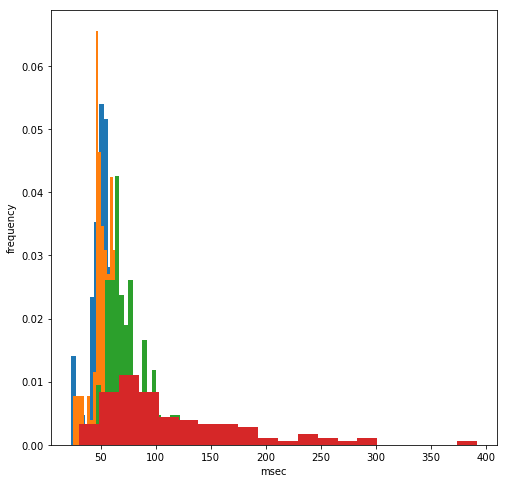

In [11]:
run_analysis( accessor.PycamhdAccessor( local_path ), ["pycamhd","local_disk"], count=reps)

# Direct LazyQT conversion

### Direct disk access

['lazyqt', 'local_disk', '1_threads']: 54.990089 ms per frame
Total time: 5501.704454
120.636463 msec to save results
['lazyqt', 'local_disk', '2_threads']: 73.126729 ms per frame
Total time: 5496.733665
119.767427 msec to save results
['lazyqt', 'local_disk', '4_threads']: 119.710262 ms per frame
Total time: 5616.027117
118.894339 msec to save results
['lazyqt', 'local_disk', '8_threads']: 173.158572 ms per frame
Total time: 5598.857880
120.319366 msec to save results


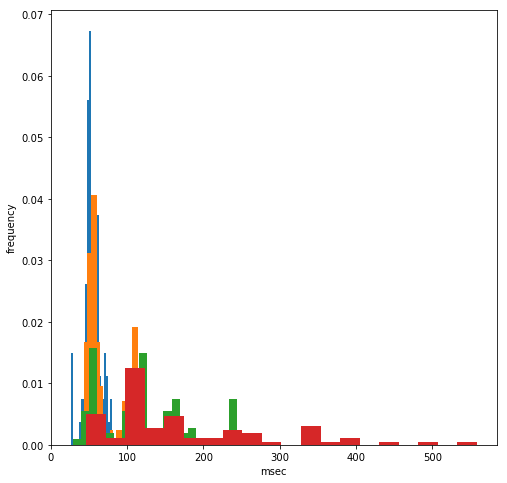

In [12]:
run_analysis( lazyqt.LazyQtAccessor( local_path ), ["lazyqt","local_disk"], count=reps)

### Local HTTP server serving local data

['lazyqt', 'local_nginx', '1_threads']: 61.939793 ms per frame
Total time: 6196.569443
157.085419 msec to save results
['lazyqt', 'local_nginx', '2_threads']: 88.855686 ms per frame
Total time: 6275.485754
120.539188 msec to save results
['lazyqt', 'local_nginx', '4_threads']: 129.920177 ms per frame
Total time: 6310.860395
120.252848 msec to save results
['lazyqt', 'local_nginx', '8_threads']: 195.566554 ms per frame
Total time: 6423.679113
120.302439 msec to save results


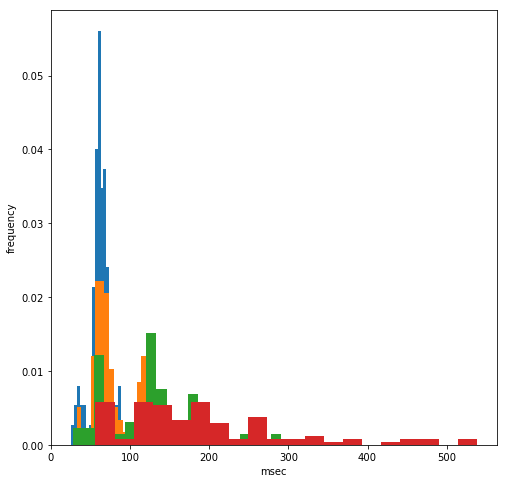

In [13]:
run_analysis( lazyqt.LazyQtAccessor( local_nginx_url ), ["lazyqt","local_nginx"], count=reps )

### Contacting CI directly 

['lazyqt', 'ci', '1_threads']: 410.497613 ms per frame
Total time: 41052.379131
120.304823 msec to save results
['lazyqt', 'ci', '2_threads']: 563.680232 ms per frame
Total time: 40265.336037
118.968010 msec to save results
['lazyqt', 'ci', '4_threads']: 864.161031 ms per frame
Total time: 40642.595053
121.977806 msec to save results
['lazyqt', 'ci', '8_threads']: 1358.261774 ms per frame
Total time: 39922.274828
124.043465 msec to save results


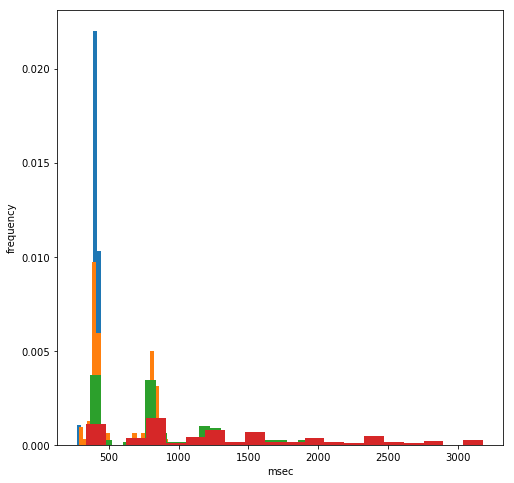

In [14]:
run_analysis( lazyqt.LazyQtAccessor( ci_url_root ), ["lazyqt","ci"], count=reps )

# Local lazycache server, non-caching


### Using local disk

In [17]:
def lazycache_berna( host ):
    return lazycache.LazycacheAccessor("%s/v1/berna/srv/data/" % host)

def lazycache_nginx( host ):
    return lazycache.LazycacheAccessor("%s/v1/nginx_data/" % host)

def lazycache_ci( host ):
        return lazycache.LazycacheAccessor("%s/v1/org/oceanobservatories/rawdata/files/" % host)
    
keys = ["lazycache","local","uncached"]

Setting random seed to 46695
['lazycache', 'local', 'uncached', 'local_disk', '1_threads']: 114.497032 ms per frame
Total time: 11557.128668
163.578510 msec to save results
Setting random seed to 46697
['lazycache', 'local', 'uncached', 'local_disk', '2_threads']: 128.283587 ms per frame
Total time: 6526.489973
125.236511 msec to save results
Setting random seed to 46701
['lazycache', 'local', 'uncached', 'local_disk', '4_threads']: 170.169635 ms per frame
Total time: 4360.537767
125.800848 msec to save results
Setting random seed to 46709
['lazycache', 'local', 'uncached', 'local_disk', '8_threads']: 356.208324 ms per frame
Total time: 4604.364872
123.940229 msec to save results
Setting random seed to 46695
['lazycache', 'local', 'uncached', 'local_disk', '1_threads']: 103.750188 ms per frame
Total time: 10487.240314
124.630213 msec to save results
Setting random seed to 46697
['lazycache', 'local', 'uncached', 'local_disk', '2_threads']: 109.484379 ms per frame
Total time: 5580.51967

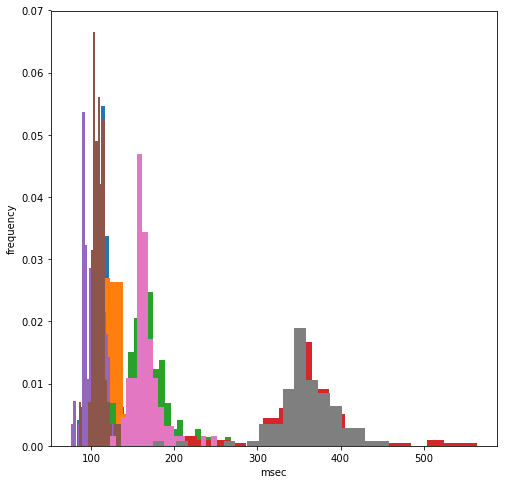

In [18]:

## run this one twice to demonstrate caching isn't enabled

seed = random.randint(0,65535)
repo = lazycache_berna( local_uncached_url )

run_analysis( repo, keys + ["local_disk"], seed = seed, count=reps  )
run_analysis( repo, keys + ["local_disk"], seed = seed, count=reps  )

### connecting to local HTTP server

['lazycache', 'local', 'uncached', 'local_nginx', '1_threads']: 117.371118 ms per frame
Total time: 11847.505808
160.935879 msec to save results
['lazycache', 'local', 'uncached', 'local_nginx', '2_threads']: 133.917220 ms per frame
Total time: 6788.667440
125.204563 msec to save results
['lazycache', 'local', 'uncached', 'local_nginx', '4_threads']: 187.438080 ms per frame
Total time: 4786.308765
123.828888 msec to save results
['lazycache', 'local', 'uncached', 'local_nginx', '8_threads']: 358.916237 ms per frame
Total time: 4608.376503
124.814034 msec to save results


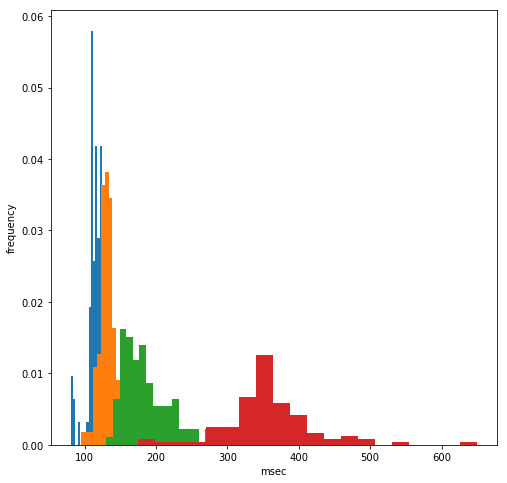

In [19]:
run_analysis( lazycache_nginx( local_uncached_url ), keys + ["local_nginx"], count=reps  )

### contacting CI directly

['lazycache', 'local', 'uncached', 'ci', '1_threads']: 251.939583 ms per frame
Total time: 25308.362961
124.163151 msec to save results
['lazycache', 'local', 'uncached', 'ci', '2_threads']: 257.343154 ms per frame
Total time: 12982.749939
123.814344 msec to save results
['lazycache', 'local', 'uncached', 'ci', '4_threads']: 283.267407 ms per frame
Total time: 7239.737749
123.084784 msec to save results
['lazycache', 'local', 'uncached', 'ci', '8_threads']: 388.153098 ms per frame
Total time: 5034.237146
124.662161 msec to save results


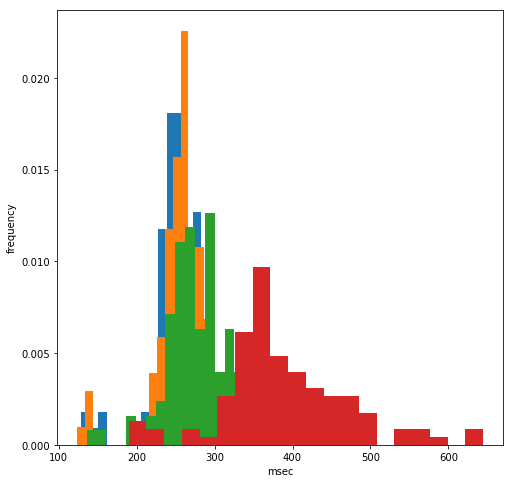

In [20]:
run_analysis( lazycache_ci( local_uncached_url ), keys + ["ci"], count=reps  )

# Local Lazycache server, with caching enabled


Setting random seed to 26157
['lazycache', 'local', 'cached', 'local_disk', '1_threads']: 116.523402 ms per frame
Total time: 11760.912418
123.884439 msec to save results
Setting random seed to 26159
['lazycache', 'local', 'cached', 'local_disk', '2_threads']: 127.892141 ms per frame
Total time: 6491.461039
125.798941 msec to save results
Setting random seed to 26163
['lazycache', 'local', 'cached', 'local_disk', '4_threads']: 173.125522 ms per frame
Total time: 4434.094667
123.559713 msec to save results
Setting random seed to 26171
['lazycache', 'local', 'cached', 'local_disk', '8_threads']: 363.417890 ms per frame
Total time: 4683.471203
125.062227 msec to save results
Setting random seed to 26157
['lazycache', 'local', 'cached', 'local_disk', '1_threads']: 58.007898 ms per frame
Total time: 5916.731358
128.741741 msec to save results
Setting random seed to 26159
['lazycache', 'local', 'cached', 'local_disk', '2_threads']: 100.137699 ms per frame
Total time: 5138.247728
125.043392 m

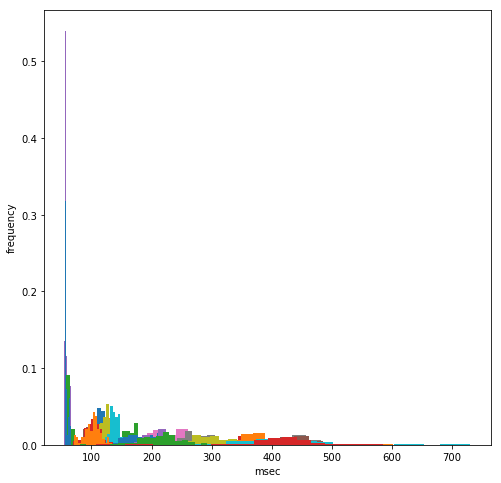

In [21]:
keys = ["lazycache","local","cached"]

seed = random.randint(0,65535)
run_analysis( lazycache_berna( local_cached_url ), keys + ["local_disk"], seed = seed, count=reps )
run_analysis( lazycache_berna( local_cached_url ), keys + ["local_disk"], seed = seed, count=reps )

seed = random.randint(0,65535)
run_analysis( lazycache_nginx( local_cached_url ), keys + ["local_nginx"], seed = seed, count=reps  )
run_analysis( lazycache_nginx( local_cached_url ), keys + ["local_nginx"], seed = seed, count=reps  )

seed = random.randint(0,65535)
run_analysis( lazycache_ci( local_cached_url ), keys + ["ci"], seed = seed, count=reps  )
run_analysis( lazycache_ci( local_cached_url ), keys + ["ci"], seed = seed, count=reps  )

# Google App Engine instance of Lazycache

## Without cache

Setting random seed to 37173
['lazycache', 'gae', 'uncached', 'ci', '1_threads']: 1984.292545 ms per frame
Total time: 198568.649769
128.166437 msec to save results
Setting random seed to 37175
['lazycache', 'gae', 'uncached', 'ci', '2_threads']: 2423.733733 ms per frame
Total time: 122124.296665
162.740707 msec to save results
Setting random seed to 37179
['lazycache', 'gae', 'uncached', 'ci', '4_threads']: 4186.570470 ms per frame
Total time: 105959.974289
125.158787 msec to save results
Setting random seed to 37187
['lazycache', 'gae', 'uncached', 'ci', '8_threads']: 7919.760404 ms per frame
Total time: 101386.106968
125.928402 msec to save results
Setting random seed to 37173
['lazycache', 'gae', 'uncached', 'ci', '1_threads']: 2164.515719 ms per frame
Total time: 216460.245848
125.523806 msec to save results
Setting random seed to 37175
['lazycache', 'gae', 'uncached', 'ci', '2_threads']: 1946.511493 ms per frame
Total time: 98330.457687
125.186443 msec to save results
Setting ran

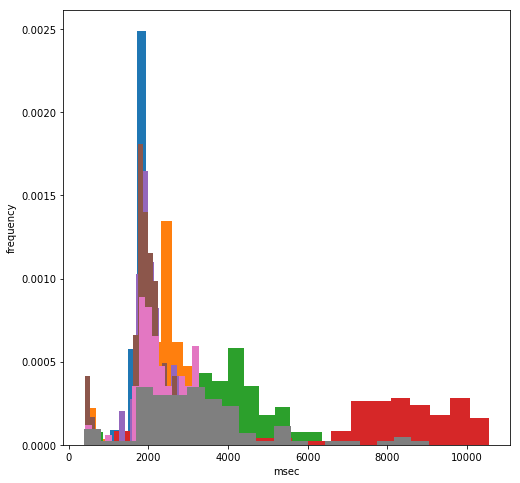

In [23]:
keys = ["lazycache", "gae", "uncached"]

seed = random.randint(0,65535)
run_analysis( lazycache_ci( gae_uncached_url ), keys + ["ci"], seed = seed, count=reps )
run_analysis( lazycache_ci( gae_uncached_url ), keys + ["ci"], seed = seed, count=reps  )

### With cache

Setting random seed to 51102
['lazycache', 'gae', 'cached', 'ci', '1_threads']: 3982.602952 ms per frame
Total time: 398268.641949
127.576351 msec to save results
Setting random seed to 51104
['lazycache', 'gae', 'cached', 'ci', '2_threads']: 3190.088801 ms per frame
Total time: 160369.630575
125.606537 msec to save results
Setting random seed to 51108
['lazycache', 'gae', 'cached', 'ci', '4_threads']: 4229.039333 ms per frame
Total time: 107529.621124
125.923872 msec to save results
Setting random seed to 51116
['lazycache', 'gae', 'cached', 'ci', '8_threads']: 7839.701021 ms per frame
Total time: 98899.915457
126.422405 msec to save results
Setting random seed to 51102
['lazycache', 'gae', 'cached', 'ci', '1_threads']: 892.129242 ms per frame
Total time: 89227.586031
124.716759 msec to save results
Setting random seed to 51104
['lazycache', 'gae', 'cached', 'ci', '2_threads']: 1009.796507 ms per frame
Total time: 50697.584867
124.768019 msec to save results
Setting random seed to 511

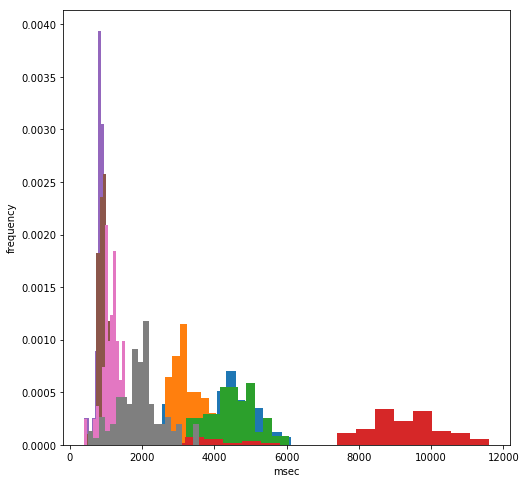

In [22]:
keys = ["lazycache", "gae", "cached"]

seed = random.randint(0,65535)
run_analysis( lazycache_ci( gae_cached_url ), keys + ["ci"], seed = seed, count=reps  )
run_analysis( lazycache_ci( gae_cached_url ), keys + ["ci"], seed = seed, count=reps  )